In [1]:
from google.colab import drive
drive.mount('/content/drive')

import os
os.chdir('/content/drive/MyDrive')

Mounted at /content/drive


In [2]:
import pandas as pd
df = pd.read_csv('output_1145_1.csv')
#df = pd.read_csv('sorted_file_9.csv')
df.head()

,time,prate,pr_wtr,pres,air,tmp
0,1948/1/1,1.910000e-06,1.418707,101080.0,234.98190,252.09000
1,1948/2/1,2.180000e-06,2.181035,100300.0,237.22414,253.86000
2,1948/3/1,3.610000e-06,2.823545,100390.0,242.24744,253.00000
3,1948/4/1,9.530000e-07,2.155997,101290.0,246.99667,257.83002
4,1948/5/1,1.400000e-05,7.325806,101190.0,267.25230,266.32000


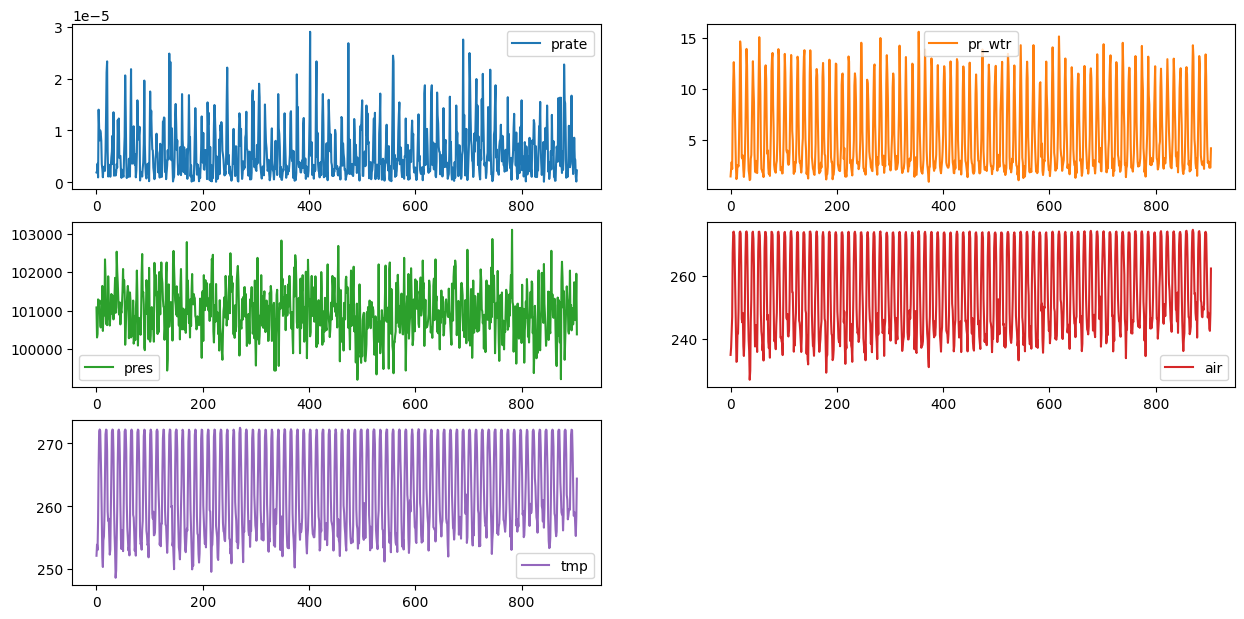

In [3]:
import matplotlib.pyplot as plt
# 时间序列图
df.plot(subplots=True, layout=(6, 2), figsize=(15, 15), sharex=False)
plt.show()

In [4]:
from statsmodels.tsa.stattools import adfuller

df['time'] = pd.to_datetime(df['time'])
df.set_index('time', inplace=True)

def adf_test(timeseries):
    # Perform Dickey-Fuller test
    dftest = adfuller(timeseries, autolag='AIC')
    return dftest[1]  # Return p-value

# Assume df is a pandas DataFrame where each column is a time series
p_values = df.apply(adf_test)

print(p_values)

prate     8.000102e-12
pr_wtr    3.948611e-07
pres      9.062099e-10
air       2.700682e-02
tmp       1.556175e-02
dtype: float64


In [5]:
#df['time'] = pd.to_datetime(df['time'])
#df.set_index('time', inplace=True)

In [6]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN
from sklearn.preprocessing import MinMaxScaler


# 总的数据量
n_total = len(df)

# 训练数据的数量，例如，前80%的数据
n_train = int(n_total * 0.8)

# 划分训练集和测试集
train_df = df[:n_train]
test_df = df[n_train:]


# 对于特征和目标变量进行划分
X_train = train_df.drop('prate', axis=1).values
y_train = train_df['prate'].values
X_test = test_df.drop('prate', axis=1).values
y_test = test_df['prate'].values


# 数据归一化
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_train = scaler_X.fit_transform(X_train)
y_train = scaler_y.fit_transform(y_train.reshape(-1, 1))

X_test = scaler_X.transform(X_test)
y_test = scaler_y.transform(y_test.reshape(-1, 1))




# 定义模型
model = Sequential()
model.add(SimpleRNN(50, activation='relu', input_shape=(X_train.shape[1], 1)))
model.add(Dense(1))

# 编译模型
model.compile(optimizer='adam', loss='mean_squared_error')


# 将训练集和测试集的形状转化为三维，以符合 RNN 的输入要求
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# 训练模型
history = model.fit(X_train, y_train, epochs=100, batch_size=128, validation_data=(X_test, y_test))

# 使用训练的模型进行预测
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# 将预测结果反归一化，以便我们可以在原始尺度上解释它们
train_predict = scaler_y.inverse_transform(train_predict)
y_train = scaler_y.inverse_transform(y_train)
test_predict = scaler_y.inverse_transform(test_predict)
y_test = scaler_y.inverse_transform(y_test)


Epoch 1/100
6/6 [==============================] - 7s 63ms/step - loss: 0.0700 - val_loss: 0.0326
Epoch 2/100
6/6 [==============================] - 0s 12ms/step - loss: 0.0245 - val_loss: 0.0204
Epoch 3/100
6/6 [==============================] - 0s 15ms/step - loss: 0.0185 - val_loss: 0.0229
Epoch 4/100
6/6 [==============================] - 0s 13ms/step - loss: 0.0178 - val_loss: 0.0193
Epoch 5/100
6/6 [==============================] - 0s 12ms/step - loss: 0.0145 - val_loss: 0.0160
Epoch 6/100
6/6 [==============================] - 0s 12ms/step - loss: 0.0138 - val_loss: 0.0156
Epoch 7/100
6/6 [==============================] - 0s 11ms/step - loss: 0.0137 - val_loss: 0.0156
Epoch 8/100
6/6 [==============================] - 0s 12ms/step - loss: 0.0132 - val_loss: 0.0161
Epoch 9/100
6/6 [==============================] - 0s 11ms/step - loss: 0.0131 - val_loss: 0.0164
Epoch 10/100
6/6 [==============================] - 0s 12ms/step - loss: 0.0127 - val_loss: 0.0156
Epoch 11/100
6/6 [=

In [9]:
# 评估模型
model.evaluate(X_test, y_test)

6/6 [==============================] - 0s 7ms/step - loss: 0.0632


0.06316523998975754

In [10]:
# 输出最佳模型的loss, val_loss
print('Best loss: ', min(history.history['loss']))
print('Best val_loss: ', min(history.history['val_loss']))

Best loss:  0.010873448103666306
Best val_loss:  0.014644313603639603


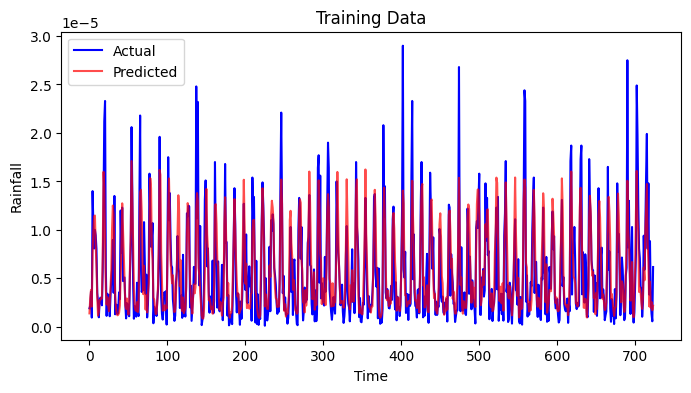

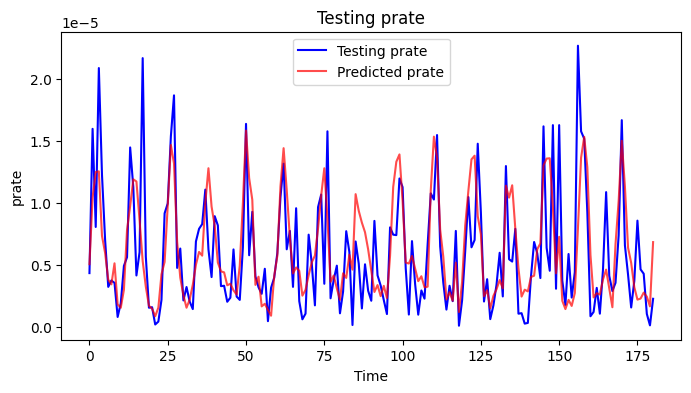

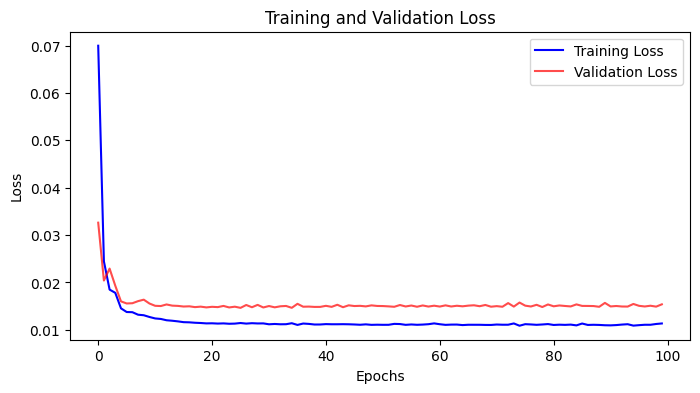

In [8]:
# 绘制训练效果图
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 4))
plt.plot(y_train, color='blue', label='Actual')
plt.plot(train_predict, alpha=0.7, color='red', label='Predicted')
plt.title('Training Data')
plt.xlabel('Time')
plt.ylabel('Rainfall')
plt.legend()
plt.show()

# 绘制测试效果图
plt.figure(figsize=(8, 4))
plt.plot(y_test, color='blue', label='Testing prate')
plt.plot(test_predict, alpha=0.7, color='red', label='Predicted prate')
plt.title('Testing prate')
plt.xlabel('Time')
plt.ylabel('prate')
plt.legend()
plt.show()

# 绘制训练时的loss和val_loss
plt.figure(figsize=(8, 4))
plt.plot(history.history['loss'], color='blue', label='Training Loss')
plt.plot(history.history['val_loss'], alpha=0.7, color='red', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()